In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mcollections
import re
import tkinter as tk
from tkinter import filedialog
import numpy as np
import os
import traceback # エラー詳細表示用

In [2]:
# --- 4. matplotlibを用いたデータプロット関数 ---
def plot_nmr_data(filepath, total_residues, exclude_outliers=False, outlier_column=None, outlier_threshold=None):
    """
    指定されたCSVファイルからChemical_Shift_DifferenceとIntensity_Ratioを読み込み、
    Assignment列の残基番号を横軸にしてプロットします。
    残基番号の範囲をtotal_residuesで指定し、データがない残基は灰色で表示します。
    外れ値を除外する場合、指定された列と閾値に基づいて残基を除外し、灰色で表示します。
    Chemical_Shift_Differenceの上位10%の残基を特別な色で表示し、残基名を棒の上に表示します。
    """
    if not os.path.exists(filepath):
        print(f"エラー: ファイル '{filepath}' が存在しません。")
        return

    if not isinstance(total_residues, int) or total_residues <= 0:
        print(f"エラー: 無効なアミノ酸総数 '{total_residues}' です。正の整数を入力してください。")
        return

    print(f"\n--- NMRデータプロット処理開始 ---")
    print(f"対象ファイル: {os.path.basename(filepath)}")
    print(f"指定されたアミノ酸総数（X軸最大値）: {total_residues}")

    try:
        df = pd.read_csv(filepath, encoding='utf-8')

        print(f"\n--- 読み込んだデータの最初の数行 ---")
        print(df.head())

        required_cols = ['Assignment', 'Chemical_Shift_Difference', 'Intensity_Ratio']
        for col in required_cols:
            if col not in df.columns:
                print(f"エラー: '{os.path.basename(filepath)}' に必要な列 '{col}' が見つかりません。")
                return

        # 'Assignment' 列から残基番号を抽出
        df['Residue_Number'] = df['Assignment'].apply(lambda x: re.search(r'\d+', str(x)).group(0) if re.search(r'\d+', str(x)) else None)
        df['Residue_Number'] = pd.to_numeric(df['Residue_Number'], errors='coerce')

        # 残基番号が抽出できなかった行やNaNになった行を削除
        df.dropna(subset=['Residue_Number'], inplace=True)
        # 残基番号でソート (プロットの線がきれいになるように)
        df.sort_values('Residue_Number', inplace=True)
        
        # 'Residue_Number' を整数型に変換
        df['Residue_Number'] = df['Residue_Number'].astype(int)

        if df.empty:
            print("エラー: 処理できるデータが見つかりませんでした。Assignment列の形式を確認してください。")
            return

        # 全ての残基番号のリストを生成
        all_residues = set(range(1, total_residues + 1))
        # データがある残基番号のセット (初期状態)
        present_residues = set(df['Residue_Number'].unique())
        # データがない残基番号のセット (初期状態)
        missing_residues_initial = all_residues - present_residues
        
        excluded_outlier_residues = set() # 外れ値として除外された残基を格納するセット

        # 外れ値の除外処理
        if exclude_outliers and outlier_column and outlier_threshold is not None:
            # 必要な列がdfに存在するか確認
            if outlier_column not in df.columns:
                print(f"警告: 指定された外れ値対象列 '{outlier_column}' がデータフレームに存在しません。外れ値除外はスキップされます。")
            elif outlier_column not in required_cols[1:]: # Assignmentは数値ではないので除外
                print(f"警告: 指定された外れ値対象列 '{outlier_column}' は数値データ列ではありません。'Chemical_Shift_Difference' または 'Intensity_Ratio' を指定してください。外れ値除外はスキップされます。")
            else:
                initial_df_len = len(df)
                # 外れ値の条件を適用
                outlier_mask = (df[outlier_column] > outlier_threshold)
                
                # 外れ値として除外される残基番号を特定
                excluded_outlier_residues = set(df.loc[outlier_mask, 'Residue_Number'].unique())
                
                # 外れ値を除外したデータフレームを作成
                df = df[~outlier_mask]
                
                print(f"\n--- 外れ値除外情報 ---")
                print(f"対象列: '{outlier_column}', 閾値: > {outlier_threshold}")
                print(f"外れ値として除外された残基数: {len(excluded_outlier_residues)}")
                print(f"除外された残基番号: {sorted(list(excluded_outlier_residues))}")
                print(f"外れ値除外後のデータ行数: {len(df)} (元: {initial_df_len})")

        # 最終的にグラフから除外される（灰色で表示される）残基を結合
        # 初期欠損残基 + 外れ値として除外された残基
        all_excluded_residues = missing_residues_initial.union(excluded_outlier_residues)

        # 虫食い状態（および外れ値）のプロット範囲を準備
        missing_ranges = []
        if all_excluded_residues:
            sorted_excluded = sorted(list(all_excluded_residues))
            start = sorted_excluded[0]
            end = sorted_excluded[0]
            for i in range(1, len(sorted_excluded)):
                if sorted_excluded[i] == end + 1:
                    end = sorted_excluded[i]
                else:
                    missing_ranges.append((start, end)) # axvspanは開始と終了のX座標が必要
                    start = sorted_excluded[i]
                    end = sorted_excluded[i]
            missing_ranges.append((start, end)) # 最後の範囲を追加
            
        print(f"グラフから除外される（灰色で表示される）残基番号: {sorted(list(all_excluded_residues))}")
        print(f"除外残基の描画範囲（開始, 終了）: {missing_ranges}")


        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # 2つのサブプロットを作成し、X軸を共有

        # Chemical_Shift_Difference のプロット
        chemical_shift_label = (
            'Chemical Shift Difference\n'
            r'$\Delta\delta = \sqrt{(\delta H_{\text{free}} - \delta H_{\text{bound}})^2 + \left(\frac{\delta N_{\text{free}} - \delta N_{\text{bound}}}{5}\right)^2}$'
        )
        
        # 全ての残基をまず青色でプロット
        ax1.bar(df['Residue_Number'], df['Chemical_Shift_Difference'], color='blue', label=chemical_shift_label, width=0.8, align='center')
        
        # Chemical_Shift_Differenceの上位10%の残基を特定
        # データフレームが空でないことを確認
        if not df.empty:
            # 'Chemical_Shift_Difference' で降順にソートし、上位10%のインデックスを取得
            top_10_percent_count = int(len(df) * 0.10)
            if top_10_percent_count == 0 and len(df) > 0: # データが少ない場合でも最低1つは選ぶ
                top_10_percent_count = 1
            
            df_sorted_csd = df.sort_values(by='Chemical_Shift_Difference', ascending=False)
            top_10_percent_residues = df_sorted_csd.head(top_10_percent_count) # ここでは.copy()は不要

            print(f"\n--- Chemical Shift Difference 上位10%の残基 ---")
            print(top_10_percent_residues[['Assignment', 'Residue_Number', 'Chemical_Shift_Difference']])

            # 上位10%の残基を別の色で再プロット
            ax1.bar(top_10_percent_residues['Residue_Number'], top_10_percent_residues['Chemical_Shift_Difference'],
                    color='orange', width=0.8, align='center', label='Top 10% Chemical Shift Difference')
            
            # 上位10%の残基にテキストラベルを追加
            for index, row in top_10_percent_residues.iterrows():
                # ここでAssignment文字列の最後の3文字を削除
                # 例えば "ALA10-N-H" -> "ALA10"
                cleaned_assignment = row['Assignment'][:-3] 
                
                ax1.text(row['Residue_Number'], row['Chemical_Shift_Difference'],
                         cleaned_assignment, ha='center', va='bottom', fontsize=12, color='black', rotation=45)

        ax1.set_ylabel('Chemical Shift Difference (ppm)')
        ax1.set_title(f'NMR Data Analysis: {os.path.basename(filepath)}')
        ax1.grid(True, linestyle='--', alpha=0.7)
        # 凡例の位置をグラフ右上（内側）に設定し、文字サイズを調整
        ax1.legend(loc='upper right', fontsize='x-large')

        ax1.set_xlim(0.5, total_residues + 0.5)
        # X軸の目盛りを10残基ごとに設定
        ax1.set_xticks(np.arange(1, total_residues + 1, 10))
        # X軸の目盛りラベルも同様に設定
        ax1.set_xticklabels(np.arange(1, total_residues + 1, 10))


        # Intensity_Ratio のプロット
        intensity_ratio_label = (
            'Intensity Ratio\n'
            r'$ file1 / file2 $'
        )
        ax2.bar(df['Residue_Number'], df['Intensity_Ratio'], color='red', label=intensity_ratio_label, width=0.8, align='center')
        ax2.set_xlabel('Residue Number')
        ax2.set_ylabel('Intensity Ratio')
        ax2.grid(True, linestyle='--', alpha=0.7)
        # 凡例の位置をグラフ右上（内側）に設定し、文字サイズを調整
        ax2.legend(loc='upper right', fontsize='x-large')

        ax2.set_xlim(0.5, total_residues + 0.5)
        # X軸の目盛りを10残基ごとに設定
        ax2.set_xticks(np.arange(1, total_residues + 1, 10))
        # X軸の目盛りラベルも同様に設定
        ax2.set_xticklabels(np.arange(1, total_residues + 1, 10))


        # 欠損残基（および外れ値）の範囲を灰色で描画 (axvspanを使用)
        for start_res, end_res in missing_ranges:
            ax1.axvspan(start_res - 0.5, end_res + 0.5, facecolor='lightgray', alpha=0.6, zorder=0)
            ax2.axvspan(start_res - 0.5, end_res + 0.5, facecolor='lightgray', alpha=0.6, zorder=0)
            
        plt.tight_layout() # サブプロット間の余白を調整
        plt.show()

        print(f"\n--- NMRデータプロット処理完了 ---")

    except Exception as e:
        print(f"ファイルの読み込みまたはプロット中にエラーが発生しました: {e}")
        traceback.print_exc()

--- NMRデータプロットスクリプト開始 ---

--- プロットするCSVファイルを選択してください。（通常は計算結果ファイル） ---
タンパク質のアミノ酸総数（残基の最大番号）を入力してください: 169
外れ値を除外しますか？ (y/n): n

--- NMRデータプロット処理開始 ---
対象ファイル: 250623N.csv
指定されたアミノ酸総数（X軸最大値）: 169

--- 読み込んだデータの最初の数行 ---
  Assignment  w1_file1  w2_file1  Data Height_file1  w1_file2  w2_file2  \
0      T2N-H   121.882     8.514            2511406   121.889     8.507   
1      E3N-H   126.703     8.319            2585933   126.772     8.299   
2      Y4N-H   122.012     8.712            1636379   121.717     8.724   
3      K5N-H   123.693     9.114            2103229   124.071     9.103   
4      L6N-H   126.298     9.234            1621216   126.869     9.305   

   Data Height_file2  w1_diff  w2_diff  Chemical_Shift_Difference  \
0             301029   -0.007    0.007                   0.007139   
1             292420   -0.069    0.020                   0.024299   
2             224263    0.295   -0.012                   0.060208   
3             277058   -0.378    0.011              

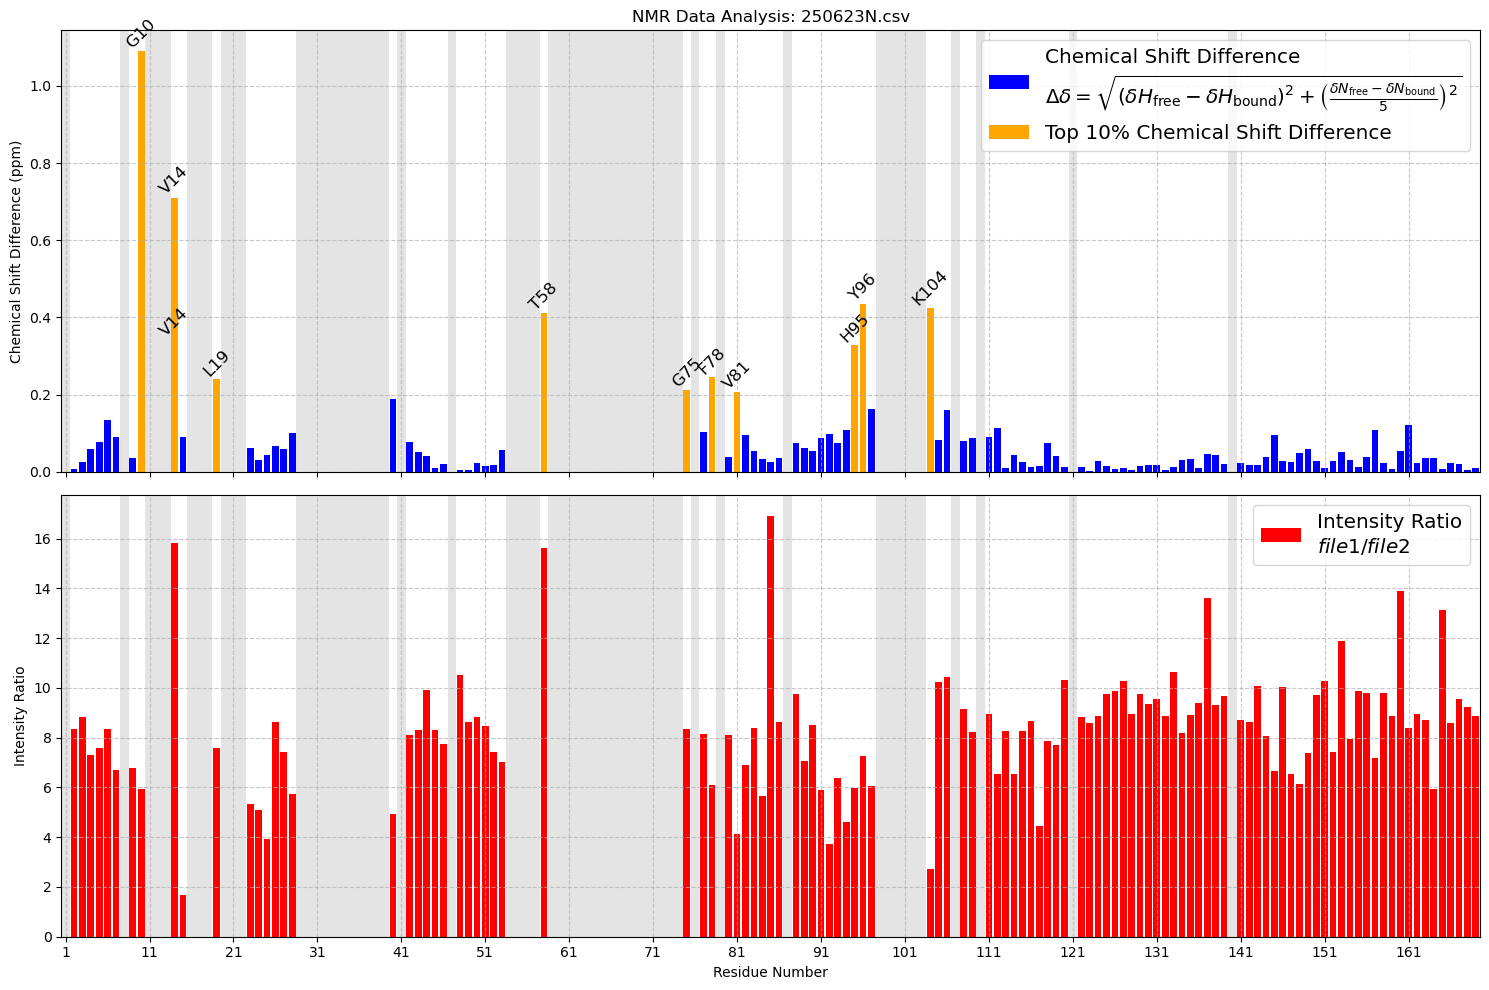


--- NMRデータプロット処理完了 ---

--- スクリプト終了 ---


In [3]:
# --- メイン実行ブロック（プロット部分のみ） ---
if __name__ == "__main__":
    # Tkinterのルートウィンドウを作成（非表示）
    root = tk.Tk()
    root.withdraw()

    print("--- NMRデータプロットスクリプト開始 ---")

    # --- フェーズ3: データプロット ---
    print("\n--- プロットするCSVファイルを選択してください。（通常は計算結果ファイル） ---")
    file_path_to_plot = filedialog.askopenfilename(title="プロット対象のCSVファイルを選択してください", filetypes=[("CSV files", "*.csv"), ("All files", "*.*")])
    
    if file_path_to_plot:
        while True:
            try:
                total_residues_input = input("タンパク質のアミノ酸総数（残基の最大番号）を入力してください: ")
                total_residues = int(total_residues_input)
                if total_residues <= 0:
                    print("エラー: 0より大きい整数を入力してください。")
                else:
                    break
            except ValueError:
                print("エラー: 無効な入力です。整数を入力してください。")

        # 外れ値除外に関するユーザー入力
        exclude_outliers_choice = input("外れ値を除外しますか？ (y/n): ").lower()
        exclude_outliers = (exclude_outliers_choice == 'y')

        outlier_col = None
        outlier_thresh = None

        if exclude_outliers:
            while True:
                outlier_col_input = input("外れ値の対象とする列名を入力してください ('Chemical_Shift_Difference' または 'Intensity_Ratio'): ")
                if outlier_col_input in ['Chemical_Shift_Difference', 'Intensity_Ratio']:
                    outlier_col = outlier_col_input
                    break
                else:
                    print("エラー: 有効な列名を入力してください。")
            
            while True:
                try:
                    outlier_thresh_input = input(f"'{outlier_col}' の外れ値のしきい値 (> この値) を入力してください (例: Chemical_Shift_Differenceが6を超える場合 '6'): ")
                    outlier_thresh = float(outlier_thresh_input)
                    break
                except ValueError:
                    print("エラー: 無効な入力です。数値を入力してください。")

        # plot_nmr_data 関数を呼び出し (外れ値パラメータを追加)
        plot_nmr_data(file_path_to_plot, total_residues,
                      exclude_outliers=exclude_outliers,
                      outlier_column=outlier_col,
                      outlier_threshold=outlier_thresh)
    else:
        print("プロットするファイルが選択されませんでした。処理を終了します。")

    print("\n--- スクリプト終了 ---")